In [1]:
import sys

sys.path.append("../")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from scipy.integrate import solve_ivp
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from typing import Optional

from src.batch_pinn import PINN, numpy_to_tensor, train
from src.utils import get_data

pd.options.mode.chained_assignment = None

np.set_printoptions(precision=4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
def plot_simulation(
    net: Optional[PINN],
    full_df: pd.DataFrame,
    t: Optional[list] = None,
    y: Optional[list] = None,
    train_df: Optional[pd.DataFrame] = None,
    net_df: Optional[pd.DataFrame] = None,
    loss: Optional[float] = None,
):
    plt.figure(figsize=(10, 5))
    plt.scatter(
        full_df["RTime"],
        full_df["Glucose"],
        label="Glucose (All)",
        color="red",
        alpha=0.2,
    )
    plt.scatter(
        full_df["RTime"],
        full_df["Biomass"],
        label="Biomass (All)",
        color="green",
        alpha=0.2,
    )
    if t is not None:
        plt.plot(t, y[0], label="Biomass (ODE)", alpha=0.3)
        plt.plot(t, y[1], label="Glucose (ODE)", alpha=0.3)
    if train_df is not None:
        plt.scatter(
            train_df["RTime"],
            train_df["Glucose"],
            label="_Glucose (Train)",
            color="red",
            alpha=1,
        )
        plt.scatter(
            train_df["RTime"],
            train_df["Biomass"],
            label="_Biomass (Train)",
            color="green",
            alpha=1,
        )
    if net_df is not None:
        plt.scatter(
            net_df["RTime"],
            net_df["Glucose"],
            marker="+",
            label="Glucose (Predicted)",
            color="red",
            s=100,
            alpha=0.5,
        )
        plt.scatter(
            net_df["RTime"],
            net_df["Biomass"],
            marker="+",
            label="Biomass (Predicted)",
            color="green",
            s=100,
            alpha=0.5,
        )

    if net is not None:
        title = f"mu_max = {net.mu_max.item():.4f}, Ks = {net.K_s.item():.4f}, Yxs = {net.Y_xs.item():.4f} || Loss = {loss:.4f}"
        plt.title(title)
    plt.legend()
    plt.show()


def simulate(df, mu_max, Ks, Yxs):
    mu_max = mu_max
    Ks = Ks
    Yxs = Yxs

    def system_ode(t, y):
        X, S = y
        mu = mu_max * S / (Ks + S)
        dXdt = mu * X
        dSdt = -mu * X / Yxs
        return [dXdt, dSdt]

    t_eval = np.linspace(df["RTime"].min(), df["RTime"].max(), 10000)
    sol = solve_ivp(
        system_ode,
        [df["RTime"].min(), df["RTime"].max()],
        [df["Biomass"].iloc[0], df["Glucose"].iloc[0]],
        t_eval=t_eval,
    )
    return sol

__Parameter estimation using PINN__

In [3]:
FILENAME = "../data/data_processed.xlsx"
EXPERIMENT = "BR01"

data = get_data(file_name=FILENAME)

df = data.loc[EXPERIMENT]

# Keep only the Batch phase
df = df[df["Process"] == "B"]
print(f"Dataset shape: {df.shape}")

Dataset shape: (8, 8)


In [4]:
# Fix 3rd data point
df["Glucose"].iloc[2] = df["Glucose"].iloc[1] - 0.2

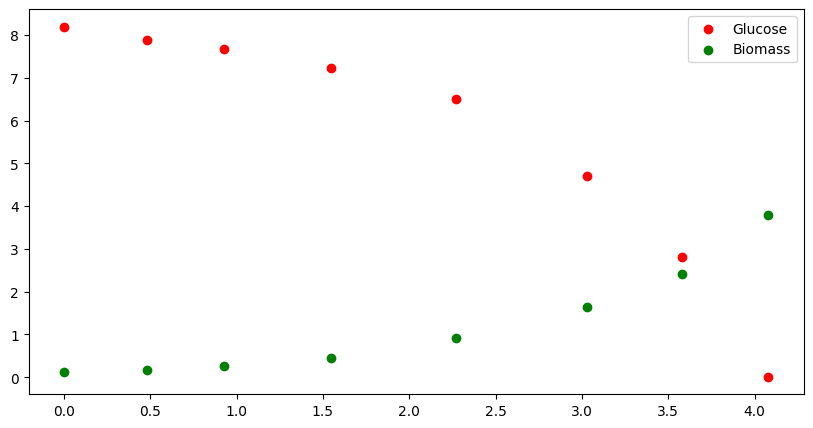

In [5]:
plt.figure(figsize=(10, 5))
plt.scatter(df["RTime"], df["Glucose"], label="Glucose", color="red")
plt.scatter(df["RTime"], df["Biomass"], label="Biomass", color="green")
plt.legend()
plt.show()

In [6]:
# # Fit a polynomial to the data
# poly = PolynomialFeatures(degree=2)
# X = poly.fit_transform(df['RTime'].values.reshape(-1, 1))
# poly_reg = LinearRegression().fit(X, df[['Biomass', 'Glucose']])
# poly_df = pd.DataFrame({'RTime': df['RTime'], 'Biomass': poly_reg.predict(X)[:, 0], 'Glucose': poly_reg.predict(X)[:, 1]})

# plot_simulation(net=None, full_df=df, net_df=poly_df)


In [7]:
# def plot_linear_model(train_df: pd.DataFrame, full_df: pd.DataFrame, pred_df: pd.DataFrame):
#     plt.figure(figsize=(10, 3))
#     plt.scatter(full_df['RTime'], full_df['Glucose'], label='Glucose (All)', color='red', alpha=0.2)
#     plt.scatter(full_df['RTime'], full_df['Biomass'], label='Biomass (All)', color='green', alpha=0.2)
#     plt.scatter(train_df['RTime'], train_df['Glucose'], label='Glucose (Train)', color='red', alpha=1)
#     plt.scatter(train_df['RTime'], train_df['Biomass'], label='Biomass (Train)', color='green', alpha=1)
#     plt.plot(pred_df['RTime'], pred_df['Glucose'], label='Glucose (Predicted)', color='red', alpha=0.5)
#     plt.plot(pred_df['RTime'], pred_df['Biomass'], label='Biomass (Predicted)', color='green', alpha=0.5)
#     plt.legend(fontsize=5, markerscale=0.5)
#     plt.xlabel('Time (h)')
#     plt.ylabel('Concentration (g/L)')
#     plt.title(f'Trained with {len(train_df)} data points')
#     plt.show()

# def fit_poly(train_df: pd.DataFrame, full_df: pd.DataFrame, degree: int = 3):
#     poly = PolynomialFeatures(degree=degree)
#     X = poly.fit_transform(train_df['RTime'].values.reshape(-1, 1))
#     poly_reg = LinearRegression().fit(X, train_df[['Biomass', 'Glucose']])
#     poly_df = pd.DataFrame({'RTime': full_df['RTime'], 'Biomass': poly_reg.predict(poly.fit_transform(full_df['RTime'].values.reshape(-1, 1)))[:, 0], \
#         'Glucose': poly_reg.predict(poly.fit_transform(full_df['RTime'].values.reshape(-1, 1)))[:, 1]})
#     return poly_df


# def fit_linear(train_df: pd.DataFrame, full_df: pd.DataFrame):
#     # Linear model
#     lin_reg = LinearRegression().fit(train_df[['RTime']], train_df[['Biomass', 'Glucose']])
#     lin_df = pd.DataFrame({'RTime': full_df['RTime'], 'Biomass': lin_reg.predict(full_df[['RTime']])[:, 0], 'Glucose': lin_reg.predict(full_df[['RTime']])[:, 1]})
#     return lin_df

# for i in range(2, len(df)+1):
#     train_df = df.iloc[:i]
#     # pred_df = fit_linear(train_df, df)
#     pred_df = fit_poly(train_df, df, degree=3)
#     plot_linear_model(train_df, df, pred_df)

Training using 2 data points
Epoch 0 || Total Loss: 63.5739, Loss Data: 31.1365, Loss IC: 32.4310, Loss ODE: 0.0064
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001


Epoch 5000 || Total Loss: 0.0238, Loss Data: 0.0173, Loss IC: 0.0035, Loss ODE: 0.0031
mu_max: 0.3660, K_s: 0.6030, Y_xs: 0.6228
Early stopping at epoch 9940
mu_max: 0.352658, Ks: 0.608301, Yxs: 0.6084


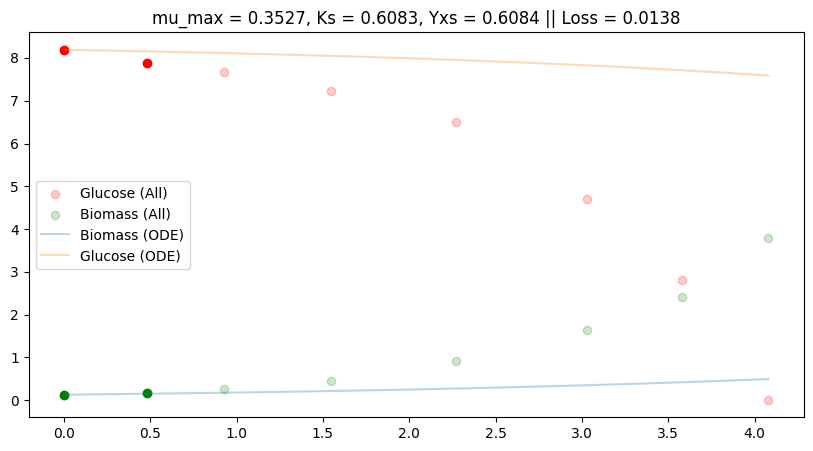

,RTime,Biomass,Glucose
0,0.00,0.136362,8.136497
1,0.48,0.130849,8.027915
2,0.93,0.130342,7.985859
3,1.55,0.129802,7.944265
4,2.27,0.126357,7.889890
5,3.03,0.123183,7.839255
6,3.58,0.121150,7.805655
7,4.08,0.119424,7.776328


Training using 3 data points
Epoch 0 || Total Loss: 62.9460, Loss Data: 30.3668, Loss IC: 32.5740, Loss ODE: 0.0051
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001
Epoch 5000 || Total Loss: 0.0482, Loss Data: 0.0350, Loss IC: 0.0096, Loss ODE: 0.0035
mu_max: 0.3672, K_s: 0.5827, Y_xs: 0.6099
Epoch 10000 || Total Loss: 0.0224, Loss Data: 0.0101, Loss IC: 0.0033, Loss ODE: 0.0090
mu_max: 0.3793, K_s: 0.5754, Y_xs: 0.4469
Epoch 15000 || Total Loss: 0.0027, Loss Data: 0.0011, Loss IC: 0.0003, Loss ODE: 0.0012
mu_max: 0.4538, K_s: 0.7219, Y_xs: 0.1598
Epoch 20000 || Total Loss: 0.0013, Loss Data: 0.0010, Loss IC: 0.0001, Loss ODE: 0.0002
mu_max: 0.4734, K_s: 0.7512, Y_xs: 0.1368
Epoch 25000 || Total Loss: 0.0012, Loss Data: 0.0010, Loss IC: 0.0001, Loss ODE: 0.0001
mu_max: 0.5152, K_s: 0.7426, Y_xs: 0.1492
mu_max: 0.556134, Ks: 0.734518, Yxs: 0.1616


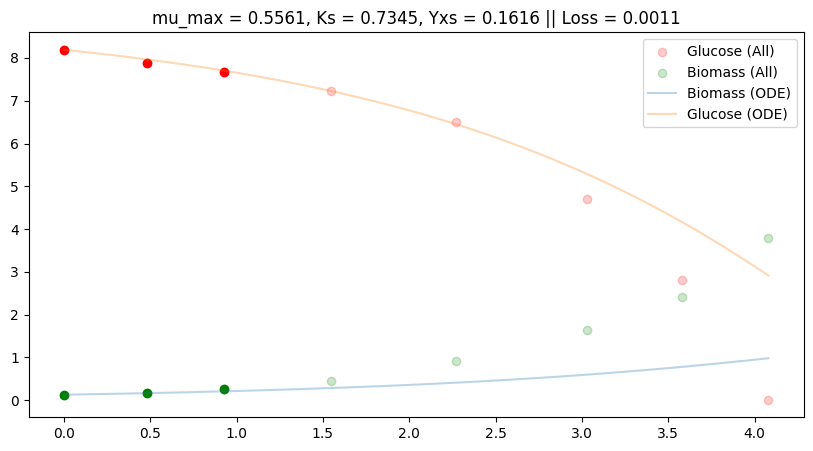

,RTime,Biomass,Glucose
0,0.00,0.139532,8.182109
1,0.48,0.182991,7.928573
2,0.93,0.232747,7.642845
3,1.55,0.320547,7.110154
4,2.27,0.459504,6.248097
5,3.03,0.667521,4.959463
6,3.58,0.866990,3.724140
7,4.08,1.084569,2.378343


Training using 4 data points
Epoch 0 || Total Loss: 63.7065, Loss Data: 30.1138, Loss IC: 33.5919, Loss ODE: 0.0008
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5000
Epoch 5000 || Total Loss: 0.1391, Loss Data: 0.0864, Loss IC: 0.0471, Loss ODE: 0.0057
mu_max: 0.2917, K_s: 0.6318, Y_xs: 0.6875
Epoch 10000 || Total Loss: 0.1255, Loss Data: 0.0974, Loss IC: 0.0274, Loss ODE: 0.0006
mu_max: 0.0895, K_s: 0.7028, Y_xs: 0.8136
Epoch 15000 || Total Loss: 0.0484, Loss Data: 0.0208, Loss IC: 0.0063, Loss ODE: 0.0213
mu_max: 0.2644, K_s: 0.4943, Y_xs: 0.5585
Epoch 20000 || Total Loss: 0.0045, Loss Data: 0.0021, Loss IC: 0.0010, Loss ODE: 0.0015
mu_max: 0.5099, K_s: 0.2230, Y_xs: 0.2677
Early stopping at epoch 24336
mu_max: 0.554829, Ks: 0.221019, Yxs: 0.2198


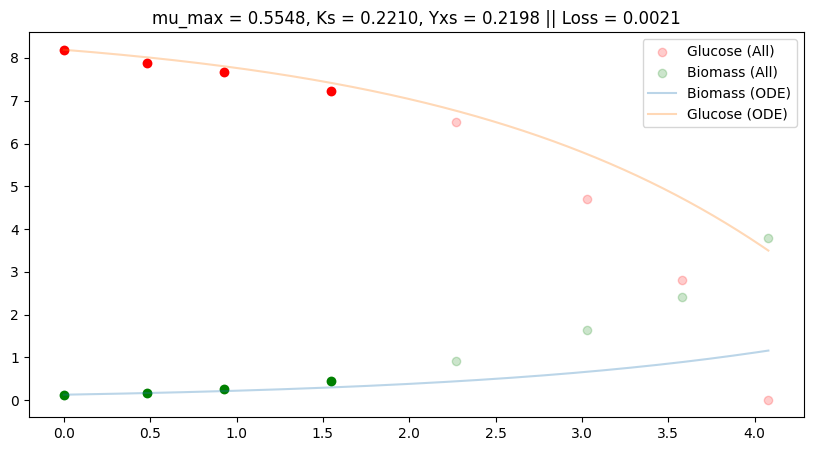

,RTime,Biomass,Glucose
0,0.00,0.147082,8.176310
1,0.48,0.204715,7.943683
2,0.93,0.268311,7.685818
3,1.55,0.389632,7.198478
4,2.27,0.572642,6.362540
5,3.03,0.855936,5.061220
6,3.58,1.144943,3.746620
7,4.08,1.481769,2.211950


Training using 5 data points
Epoch 0 || Total Loss: 56.9966, Loss Data: 25.9784, Loss IC: 31.0150, Loss ODE: 0.0031
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001
Epoch 5000 || Total Loss: 0.3666, Loss Data: 0.2907, Loss IC: 0.0663, Loss ODE: 0.0096
mu_max: 0.2685, K_s: 0.6250, Y_xs: 0.6887
Epoch 10000 || Total Loss: 0.3511, Loss Data: 0.2814, Loss IC: 0.0690, Loss ODE: 0.0007
mu_max: 0.0682, K_s: 0.7375, Y_xs: 0.8081
Epoch 15000 || Total Loss: 0.1183, Loss Data: 0.0484, Loss IC: 0.0113, Loss ODE: 0.0586
mu_max: 0.1965, K_s: 0.5562, Y_xs: 0.6168
Epoch 20000 || Total Loss: 0.0174, Loss Data: 0.0080, Loss IC: 0.0030, Loss ODE: 0.0064
mu_max: 0.4359, K_s: 0.2762, Y_xs: 0.3176
Epoch 25000 || Total Loss: 0.0092, Loss Data: 0.0058, Loss IC: 0.0009, Loss ODE: 0.0025
mu_max: 0.5155, K_s: 0.2440, Y_xs: 0.2719
mu_max: 0.600684, Ks: 0.237181, Yxs: 0.3148


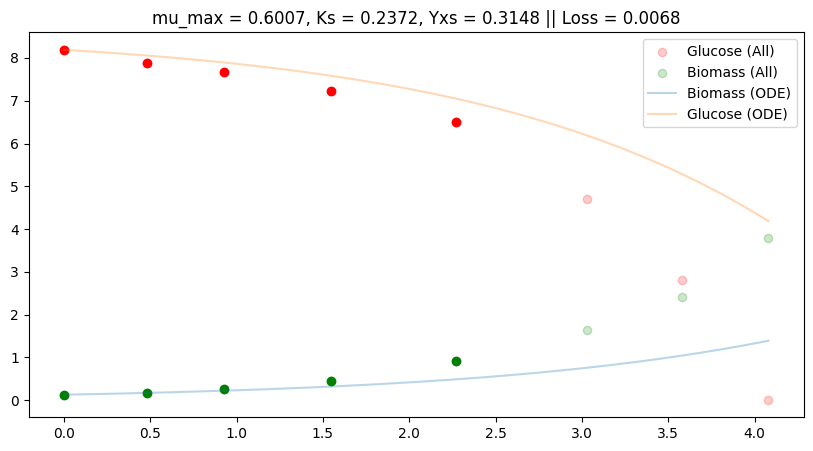

,RTime,Biomass,Glucose
0,0.00,0.160851,8.167063
1,0.48,0.237250,7.964038
2,0.93,0.321914,7.722725
3,1.55,0.486100,7.269112
4,2.27,0.780213,6.457235
5,3.03,1.205906,5.097535
6,3.58,1.648172,3.689798
7,4.08,2.174314,2.016451


Training using 6 data points
Epoch 0 || Total Loss: 58.1099, Loss Data: 25.1138, Loss IC: 32.9956, Loss ODE: 0.0006
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001
Epoch 5000 || Total Loss: 0.5790, Loss Data: 0.3607, Loss IC: 0.0657, Loss ODE: 0.1526
mu_max: 0.2652, K_s: 0.6585, Y_xs: 0.6857
Epoch 10000 || Total Loss: 0.0376, Loss Data: 0.0203, Loss IC: 0.0028, Loss ODE: 0.0145
mu_max: 0.5309, K_s: 0.3954, Y_xs: 0.3763
Epoch 15000 || Total Loss: 0.0077, Loss Data: 0.0052, Loss IC: 0.0005, Loss ODE: 0.0020
mu_max: 0.6855, K_s: 0.1964, Y_xs: 0.3652
Epoch 20000 || Total Loss: 0.0050, Loss Data: 0.0035, Loss IC: 0.0005, Loss ODE: 0.0009
mu_max: 0.7881, K_s: 0.1575, Y_xs: 0.4239
Early stopping at epoch 21220
mu_max: 0.791214, Ks: 0.162308, Yxs: 0.4232


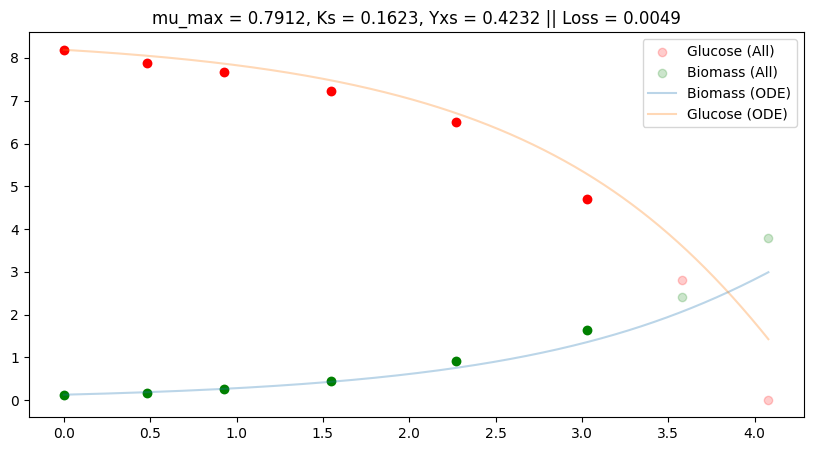

,RTime,Biomass,Glucose
0,0.00,0.147698,8.165627
1,0.48,0.220397,7.977226
2,0.93,0.310407,7.749769
3,1.55,0.501306,7.297525
4,2.27,0.888663,6.422117
5,3.03,1.613659,4.736993
6,3.58,2.446044,2.766996
7,4.08,3.466590,0.357635


Training using 7 data points
Epoch 0 || Total Loss: 58.0329, Loss Data: 23.7197, Loss IC: 34.3124, Loss ODE: 0.0008
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001
Epoch 5000 || Total Loss: 2.9377, Loss Data: 2.4725, Loss IC: 0.4450, Loss ODE: 0.0202
mu_max: 0.2067, K_s: 0.7146, Y_xs: 0.7558
Epoch 10000 || Total Loss: 0.3692, Loss Data: 0.2022, Loss IC: 0.0207, Loss ODE: 0.1463
mu_max: 0.3997, K_s: 0.4978, Y_xs: 0.4951
Epoch 15000 || Total Loss: 0.0193, Loss Data: 0.0095, Loss IC: 0.0007, Loss ODE: 0.0091
mu_max: 0.5874, K_s: 0.2693, Y_xs: 0.3275
Epoch 20000 || Total Loss: 0.0054, Loss Data: 0.0037, Loss IC: 0.0005, Loss ODE: 0.0011
mu_max: 0.7306, K_s: 0.1075, Y_xs: 0.4022
Early stopping at epoch 24200
mu_max: 0.779224, Ks: 0.089795, Yxs: 0.4247


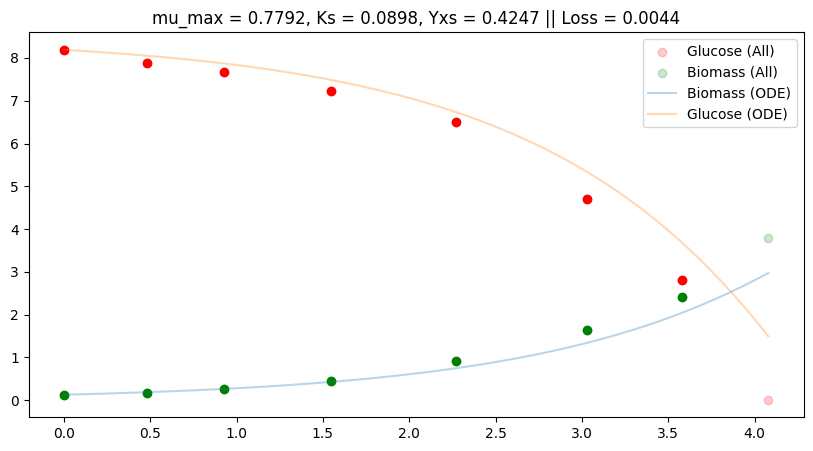

,RTime,Biomass,Glucose
0,0.00,0.148168,8.165844
1,0.48,0.224697,7.975202
2,0.93,0.312974,7.744967
3,1.55,0.502755,7.293363
4,2.27,0.887532,6.420709
5,3.03,1.598869,4.752430
6,3.58,2.426164,2.800861
7,4.08,3.483804,0.311035


Training using 8 data points
Epoch 0 || Total Loss: 56.4735, Loss Data: 21.8201, Loss IC: 34.6484, Loss ODE: 0.0050
mu_max: 0.4999, K_s: 0.5001, Y_xs: 0.5001
Epoch 5000 || Total Loss: 0.0982, Loss Data: 0.0703, Loss IC: 0.0011, Loss ODE: 0.0267
mu_max: 0.5852, K_s: 0.3852, Y_xs: 0.3744
Epoch 10000 || Total Loss: 0.0216, Loss Data: 0.0154, Loss IC: 0.0005, Loss ODE: 0.0057
mu_max: 0.7309, K_s: 0.1408, Y_xs: 0.4124
Early stopping at epoch 13935
mu_max: 0.792636, Ks: 0.004232, Yxs: 0.4431


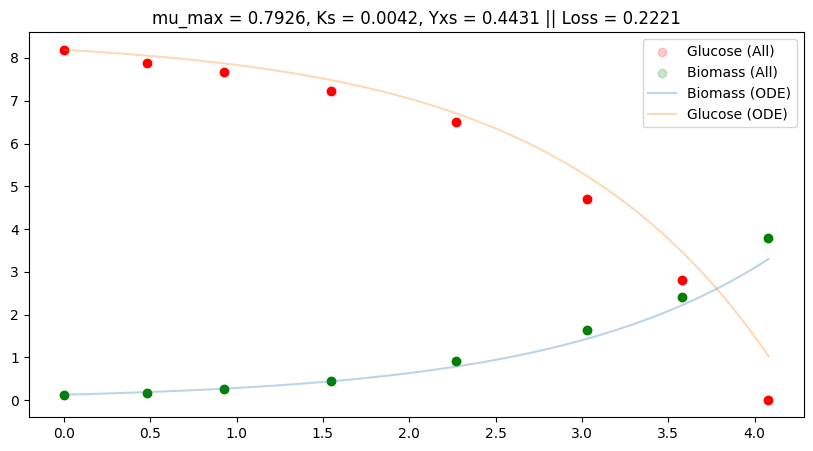

,RTime,Biomass,Glucose
0,0.00,0.148498,8.164365
1,0.48,0.222775,7.978326
2,0.93,0.313964,7.749548
3,1.55,0.503795,7.303986
4,2.27,0.889013,6.436077
5,3.03,1.621548,4.776024
6,3.58,2.504212,2.786420
7,4.08,3.719260,0.060396


In [8]:
for i in range(2, len(df)+1):
    print(f'Training using {i} data points')
    
    _df = df.iloc[:i]
    t_start, t_end = _df['RTime'].min(), _df['RTime'].max()
    
    t = numpy_to_tensor(_df['RTime'].values)
    X = numpy_to_tensor(_df['Biomass'].values)
    S = numpy_to_tensor(_df['Glucose'].values)
    X_S = torch.cat((X, S), 1)
    
    # Define and Train PINN 
    net = PINN(1, 2, t_start=t_start, t_end=t_end).to(device) 
    
    net, total_loss = train(net, t, X_S, df, num_epochs=30000, verbose=True)

    # Store the results
    net_df = pd.DataFrame(columns=['RTime', 'Biomass', 'Glucose'])
    t_test = df['RTime'].values
    net_df['RTime'] = t_test
    t_test = numpy_to_tensor(t_test)
    net_df['Biomass'] = net.forward(t_test).detach().cpu().numpy()[:, 0]
    net_df['Glucose'] = net.forward(t_test).detach().cpu().numpy()[:, 1]
    
    mu_max = net.mu_max.item()
    Ks = net.K_s.item()
    Yxs = net.Y_xs.item()
    
    print(f'mu_max: {mu_max:4f}, Ks: {Ks:4f}, Yxs: {Yxs:.4f}')
    
    solution = simulate(df, mu_max, Ks, Yxs)
    # Replace negative values with 0
    solution.y[solution.y < 0] = 0
    
    plot_simulation(net, df, solution.t, solution.y, _df, net_df=None, loss=total_loss)
    
    # Check predictions
    display(net_df)